Getting ericmjl/Circos to work in Binder, January 2018
=============

Wanted to be able to run the code in https://github.com/ericmjl/Circos/blob/master/examples.ipynb .

Trick was to use Python 2 version. Used https://github.com/binder-examples/python2_runtime

Impetus is that I want to be able to make a circular plot with filled or empty circles like they use for the nodes here. So I need to figure out how they did that in matplotlib and see if I can plot ones in inner ring.
Would also be nice to make tick marks and an to scale outermost ring, like at http://circos.ca/documentation/tutorials/2d_tracks/glyphs_1/images or http://circos.ca/documentation/tutorials/2d_tracks/glyphs_2/images.

In [ ]:
# Running in Python 2 kernel from binder examples page at https://github.com/binder-examples/python2_runtime
# Otherwise, in Python 3 I was getting errors with `G.nodes` when I tried to run `G.nodes()[0:5]` or 
# print statement errors if I tried pip installing networkx==1.2

In [2]:
!pip2 install networkx==1.1

  Using cached networkx-1.1.zip
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/a0/a6/4f/2288ad54725bd39d2f1cc3e79e7e98a54861f15952eb80a74f
Successfully built networkx


In [3]:
# pasted code from https://github.com/ericmjl/Circos/blob/master/circos/circos.py , but
# could have just used `%load https://raw.githubusercontent.com/ericmjl/Circos/master/circos/circos.py`
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.path import Path


class CircosPlot(object):
    def __init__(self, nodes, edges, radius,
                 nodecolor=None, edgecolor=None,
                 nodeprops=None, edgeprops=None,
                 figsize=(8, 8), ax=None, fig=None):
        self.nodes = nodes  # list of nodes
        self.edges = edges  # list of edge tuples

        # Make sure props are dictionaries if passed in
        # Node props
        if nodeprops is not None:
            if isinstance(nodeprops, dict):
                self.nodeprops = nodeprops
            else:
                raise TypeError("nodeprops must be a dictionary")
        else:
            self.nodeprops = {}
        # Edge props
        if edgeprops is not None:
            if isinstance(edgeprops, dict):
                self.edgeprops = edgeprops
            else:
                raise TypeError("edgeprops must be a dictionary")
        else:
            self.edgeprops = {}

        # Set colors. Priority: nodecolor > nodeprops > default
        # Node color
        if nodecolor is not None:
            self.nodecolor = nodecolor
        elif nodeprops:
            try:
                self.nodecolor = nodeprops.pop('facecolor')
            except KeyError:
                self.nodecolor = 'blue'
        else:
            self.nodecolor = 'blue'
        # Edge color
        if edgecolor is not None:
            self.edgecolor = edgecolor
        elif edgeprops:
            try:
                self.edgecolor = edgeprops.pop('edgecolor')
            except KeyError:
                self.edgecolor = 'black'
        else:
            self.edgecolor = 'black'

        self.radius = radius
        if fig is None:
            self.fig = plt.figure(figsize=figsize)
        else:
            self.fig = fig
        if ax is None:
            self.ax = self.fig.add_subplot(111)
        else:
            self.ax = ax
        self.node_radius = self.radius*0.05
        self.ax.set_xlim(-radius*1.05, radius*1.05)
        self.ax.set_ylim(-radius*1.05, radius*1.05)
        self.ax.xaxis.set_visible(False)
        self.ax.yaxis.set_visible(False)
        for k in self.ax.spines.keys():
            self.ax.spines[k].set_visible(False)

    def draw(self):
        self.add_nodes()
        self.add_edges()

    def add_nodes(self):
        """
        Draws nodes onto the canvas with colours.
        """
        r = self.radius
        node_r = self.node_radius
        # if 'color' in self.nodeprops:
        #    self.nodeprops.pop('color')
        if 'facecolor' in self.nodeprops:
            self.nodeprops.pop('facecolor')
        # Check if self.nodecolor is a string. If so, this color gets applied
        # to all nodes.
        if isinstance(self.nodecolor, str):
            nodes_and_colors = zip(self.nodes,
                                   [self.nodecolor] * len(self.nodes))
        # Check if nodecolor is an iterable. If so and same length as nodes.
        # This applies each matched color to that node.
        elif hasattr(self.nodecolor, '__iter__') and \
                (len(self.nodes) == len(self.nodecolor)):
            nodes_and_colors = zip(self.nodes, self.nodecolor)
        # Throw error if above two conditions are not met.
        else:
            raise TypeError("""nodecolor must be a string or iterable of the
                same length as nodes.""")
        # Draw the nodes to screen.
        for node, color in nodes_and_colors:
            theta = self.node_theta(node)
            x, y = get_cartesian(r, theta)
            self.nodeprops['facecolor'] = color
            node_patch = patches.Ellipse((x, y), node_r, node_r,
                                         lw=0, **self.nodeprops)
            self.ax.add_patch(node_patch)

    # def draw_edge(self, node1, node2):
    #     start_theta = self.node_theta(node1)
    #     end_theta = self.node_theta(node2)
    #     # middle_theta = (start_theta + end_theta)/2.0
    #     # delta_theta = abs(end_theta - start_theta)
    #     # middle_r = self.radius * (1 - delta_theta / np.pi)

    #     # verts = [get_cartesian(self.radius, start_theta),
    #     #          get_cartesian(middle_theta, middle_r),
    #     #          get_cartesian(self.radius,end_theta)]
    #     verts = [get_cartesian(self.radius, start_theta),
    #              (0, 0),
    #              get_cartesian(self.radius, end_theta)]
    #     codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]

    #     path = Path(verts, codes)
    #     self.edgeprops['facecolor'] = 'none'
    #     self.edgeprops['edgecolor'] = self.edgecolor
    #     patch = patches.PathPatch(path, lw=1, **self.edgeprops)
    #     self.ax.add_patch(patch)

    def node_theta(self, node):
        """
        Maps node to Angle.
        """
        i = self.nodes.index(node)
        theta = i*2*np.pi/len(self.nodes)

        return theta

    def add_edges(self):
        """
        Draws edges to screen.
        """
        for start, end in self.edges:
            start_theta = self.node_theta(start)
            end_theta = self.node_theta(end)
            verts = [get_cartesian(self.radius, start_theta),
                     (0, 0),
                     get_cartesian(self.radius, end_theta)]
            codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]

            path = Path(verts, codes)
            self.edgeprops['facecolor'] = 'none'
            self.edgeprops['edgecolor'] = self.edgecolor
            patch = patches.PathPatch(path, lw=1, **self.edgeprops)
            self.ax.add_patch(patch)


def get_cartesian(r, theta):
    x = r*np.sin(theta)
    y = r*np.cos(theta)

    return x, y

In [4]:
import networkx as nx 

In [ ]:
#uploaded `07 inter-subtype interactions.pkl` from https://github.com/ericmjl/Circos/tree/master/tests/test_graphs

In [5]:
G = nx.read_gpickle('07 inter-subtype interactions.pkl')

In [6]:
G.nodes()[0:5]

['H10N8', 'H10N9', 'H10N1', 'H10N2', 'H10N3']

In [8]:
%matplotlib notebook

<IPython.core.display.Javascript object>


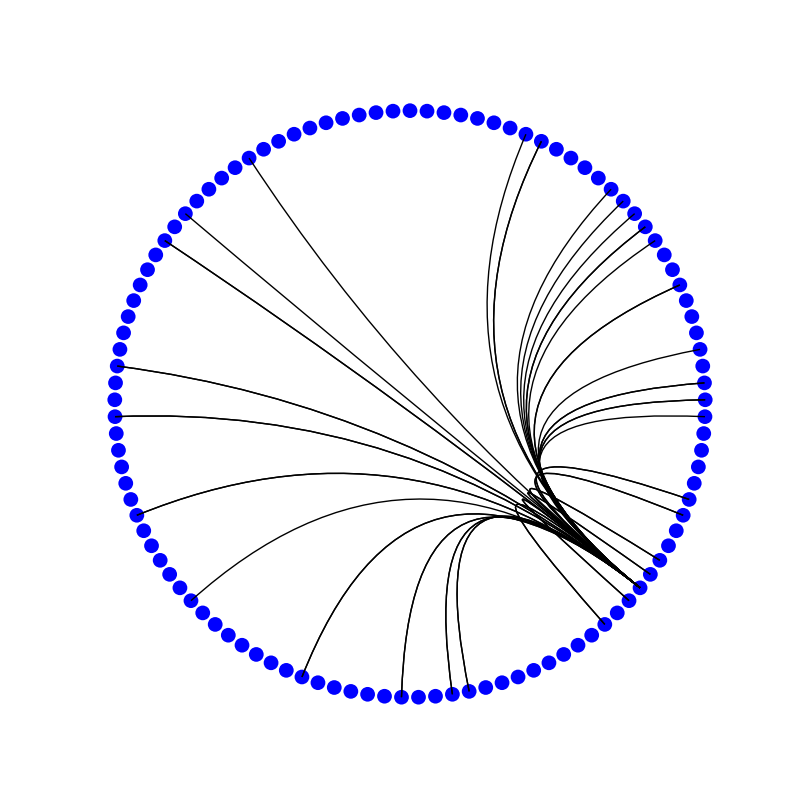

In [9]:
nodes = G.nodes()
edges = [(u, v) for u, v in G.edges() if 'H3N2' in [u, v] and u != v]

nodeprops = dict(facecolor='red', alpha=0.5)
edgeprops = dict(edgecolor='orange', alpha=0.75, ls='--')

c = CircosPlot(nodes, edges, 10,
               #nodecolor=plt.cm.viridis(np.arange(len(nodes)) / len(nodes)),
               #edgecolor='black',
               #edgeprops=edgeprops,
               #nodeprops=nodeprops
              )
c.draw()

<IPython.core.display.Javascript object>


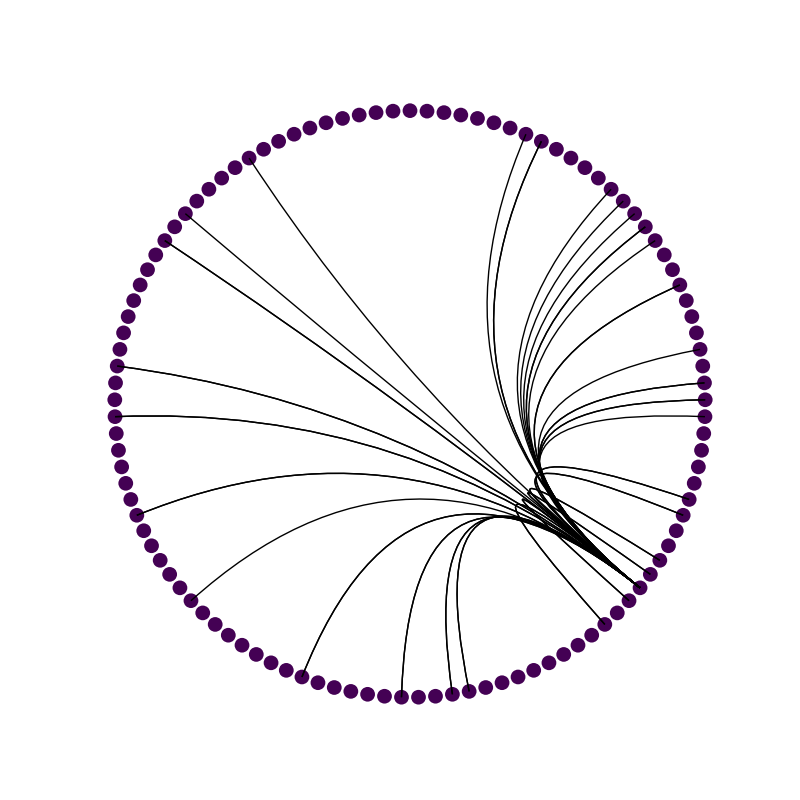

In [10]:
c = CircosPlot(nodes, edges, 10,
               nodecolor=plt.cm.viridis(np.arange(len(nodes)) / len(nodes)),
               #edgecolor='black',
               #edgeprops=edgeprops,
               #nodeprops=nodeprops
              )
c.draw()

<IPython.core.display.Javascript object>


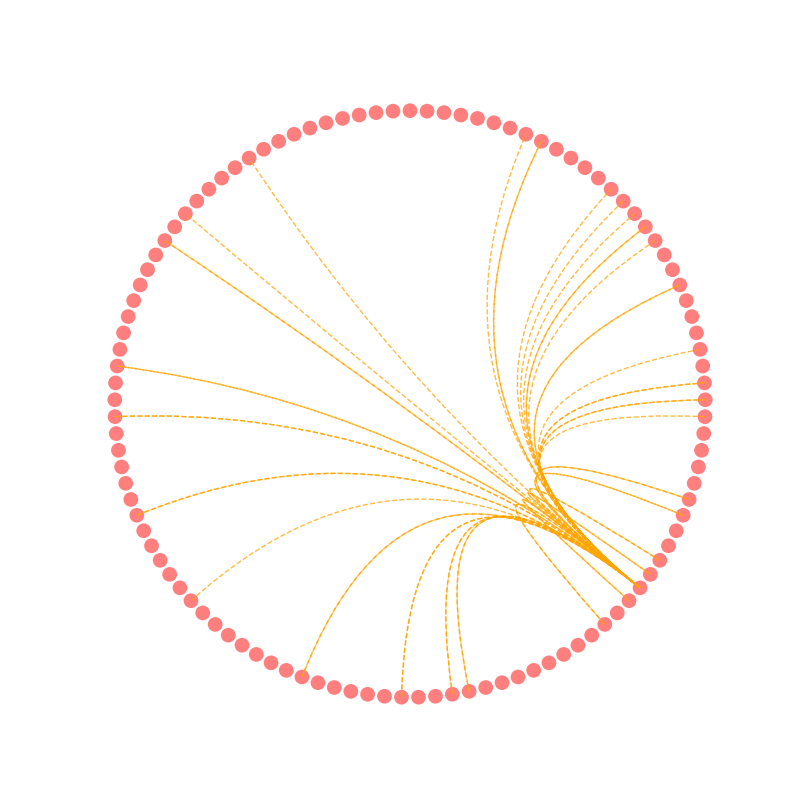

In [11]:
c = CircosPlot(nodes, edges, 10,
               #nodecolor=plt.cm.viridis(np.arange(len(nodes)) / len(nodes)),
               #edgecolor='black',
               edgeprops=edgeprops,
               nodeprops=nodeprops
              )
c.draw()

<IPython.core.display.Javascript object>


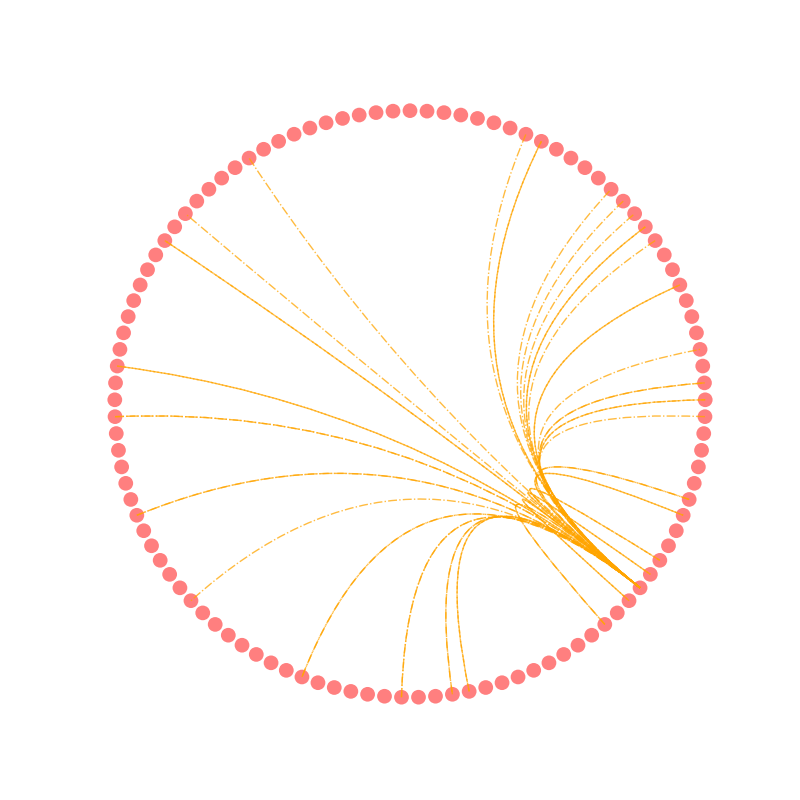

In [12]:

edgeprops = dict(edgecolor='orange', alpha=0.75, ls='-.')
c = CircosPlot(nodes, edges, 10,
               #nodecolor=plt.cm.viridis(np.arange(len(nodes)) / len(nodes)),
               #edgecolor='black',
               edgeprops=edgeprops,
               nodeprops=nodeprops
              )
c.draw()